In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun  1 08:27:46 2022

@author: Seth Sullivan

Simulating matching pennies with the agent. The difference between this and the other 
optimal decision time simulations is that this includes reaction+movement time
so the agent leaves the target at a certain time and 
"""

'\nCreated on Wed Jun  1 08:27:46 2022\n\n@author: Seth Sullivan\n\nSimulating matching pennies with the agent. The difference between this and the other \noptimal decision time simulations is that this includes reaction+movement time\nso the agent leaves the target at a certain time and \n'

In [6]:
import numpy as np 
import scipy 
from scipy.stats import norm
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import cm
import os
import random
from tqdm import tqdm
import numba as nb
from numba import njit
from numba import jit
import matplotlib.animation as animation
from textwrap import wrap
import data_visualization as dv

In [7]:
wheel = dv.ColorWheel()

In [8]:
# No gambles
num_trials = 10000
num_blocks = 6
player_reach_time = np.zeros((num_trials, num_blocks))
agent_reach_time = np.zeros((num_trials, num_blocks))
agent_leave_time = np.zeros((num_trials, num_blocks))
reaction_movement_time = np.zeros((num_trials, num_blocks))
wins = np.zeros(num_blocks)
indecisions = np.zeros(num_blocks)
agent_reach_means = [1300,1300,1400,1400,1500,1500]
agent_reach_sds = [100,200]*3
for j in range(num_blocks):
    agent_reach_time[:,j] = norm.rvs(agent_reach_means[j],agent_reach_sds[j],num_trials)
    agent_leave_time[:,j] = agent_reach_time[:,j] - 300
    reaction_movement_time[:,j] = norm.rvs(400,30,num_trials)
    player_reach_time[:,j] = agent_leave_time[:,j] + reaction_movement_time[:,j]
    wins[j] = np.count_nonzero(player_reach_time[:,j]<1500)
    indecisions[j] = np.count_nonzero(player_reach_time[:,j]>=1500)
perc_wins = wins/num_trials*100
perc_indecisions = indecisions/num_trials*100

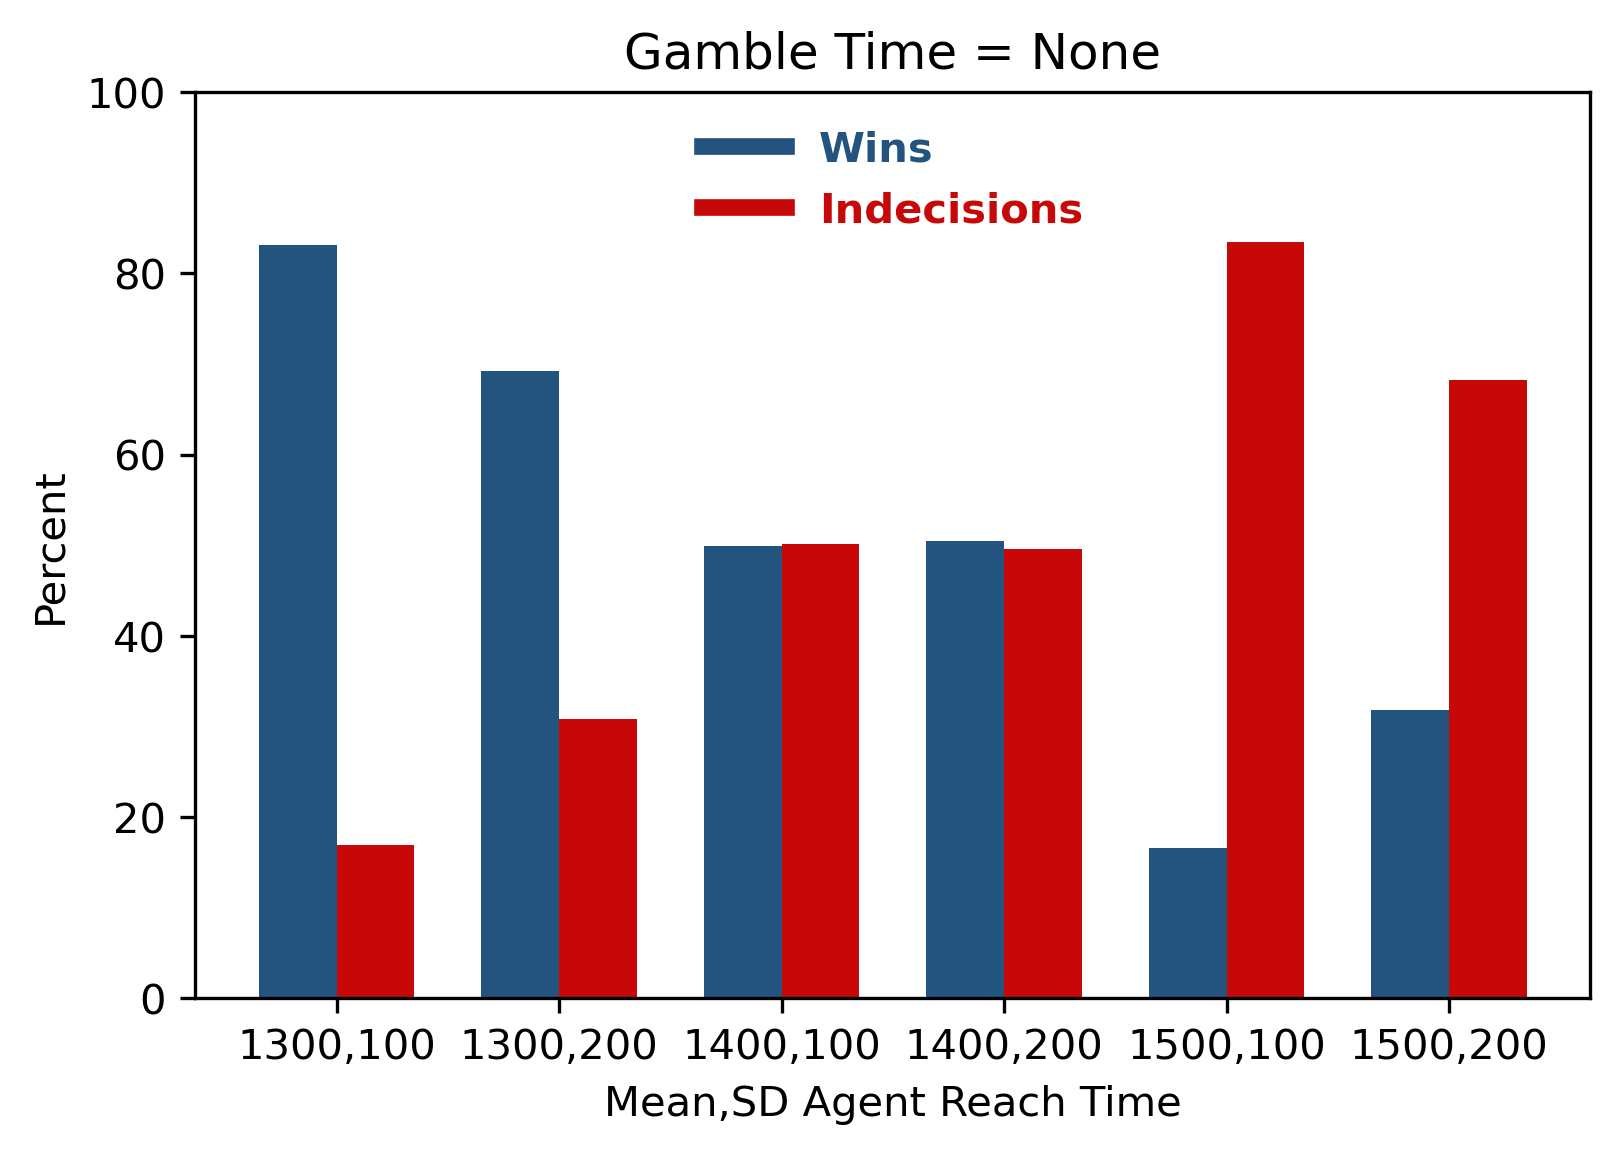

In [9]:
# Plot
plt.figure(dpi = 300)
ax = plt.subplot()
xlocs = np.arange(num_blocks)
xlabs = ['1300,100', '1300,200','1400,100', '1400,200','1500,100', '1500,200']
width = 0.35
ax.bar(xlocs - width/2 ,perc_wins, width = width, label = 'Wins', color = wheel.dark_blue)
ax.bar(xlocs + width/2, perc_indecisions, width = width, label = 'Indecisions', color = wheel.dark_red)
ax.set_xticks(xlocs)
ax.set_xticklabels(xlabs)
ax.set_xlabel('Mean,SD Agent Reach Time')
ax.set_ylabel('Percent')
ax.set_ylim(0,100)
labels = ["Wins", "Indecisions"]
colors = [wheel.dark_blue, wheel.dark_red]
dv.Custom_Legend(ax, labels, colors, fontsize = 10)
ax.set_title('Gamble Time = None')
plt.show()

In [10]:
#%% Gamble time = 1000
num_trials = 10000
num_blocks = 6
player_reach_time = np.zeros((num_trials, num_blocks))
agent_reach_time = np.zeros((num_trials, num_blocks))
agent_leave_time = np.zeros((num_trials, num_blocks))
reaction_movement_time = np.zeros((num_trials, num_blocks))
gamble_time = np.zeros((num_trials, num_blocks))
reaction_wins = np.zeros(num_blocks)
indecisions = np.zeros(num_blocks)
gamble_wins = np.zeros(num_blocks)
gamble_losses = np.zeros(num_blocks)
agent_reach_means = [1300,1300,1400,1400,1500,1500]
agent_reach_sds = [100,200]*3
gamble_time_mean, gamble_time_sd = 1500, 100 # This should be the timing ability sd from data
for j in range(num_blocks):
    agent_reach_time[:,j] = norm.rvs(agent_reach_means[j],agent_reach_sds[j],num_trials)
    agent_leave_time[:,j] = agent_reach_time[:,j] - 300
    reaction_movement_time[:,j] = norm.rvs(400,30,num_trials)
    player_reach_time[:,j] = agent_leave_time[:,j] + reaction_movement_time[:,j]
    gamble_time[:,j] = norm.rvs(gamble_time_mean, gamble_time_sd, num_trials)
for i in range(num_trials):
    for j in range(num_blocks):
        if player_reach_time[i,j]>gamble_time[i,j]:
            r = random.uniform(0,1)
            if r>0.5:
                gamble_wins[j]+=1
            else:
                gamble_losses[j]+=1
        elif player_reach_time[i,j]>1500:
            indecisions[j]+= 1
        else:
            reaction_wins[j]+=1
perc_reaction_wins = reaction_wins/num_trials*100
perc_gamble_wins = gamble_wins/num_trials*100
perc_gamble_losses = gamble_losses/num_trials*100
perc_indecisions = indecisions/num_trials*100

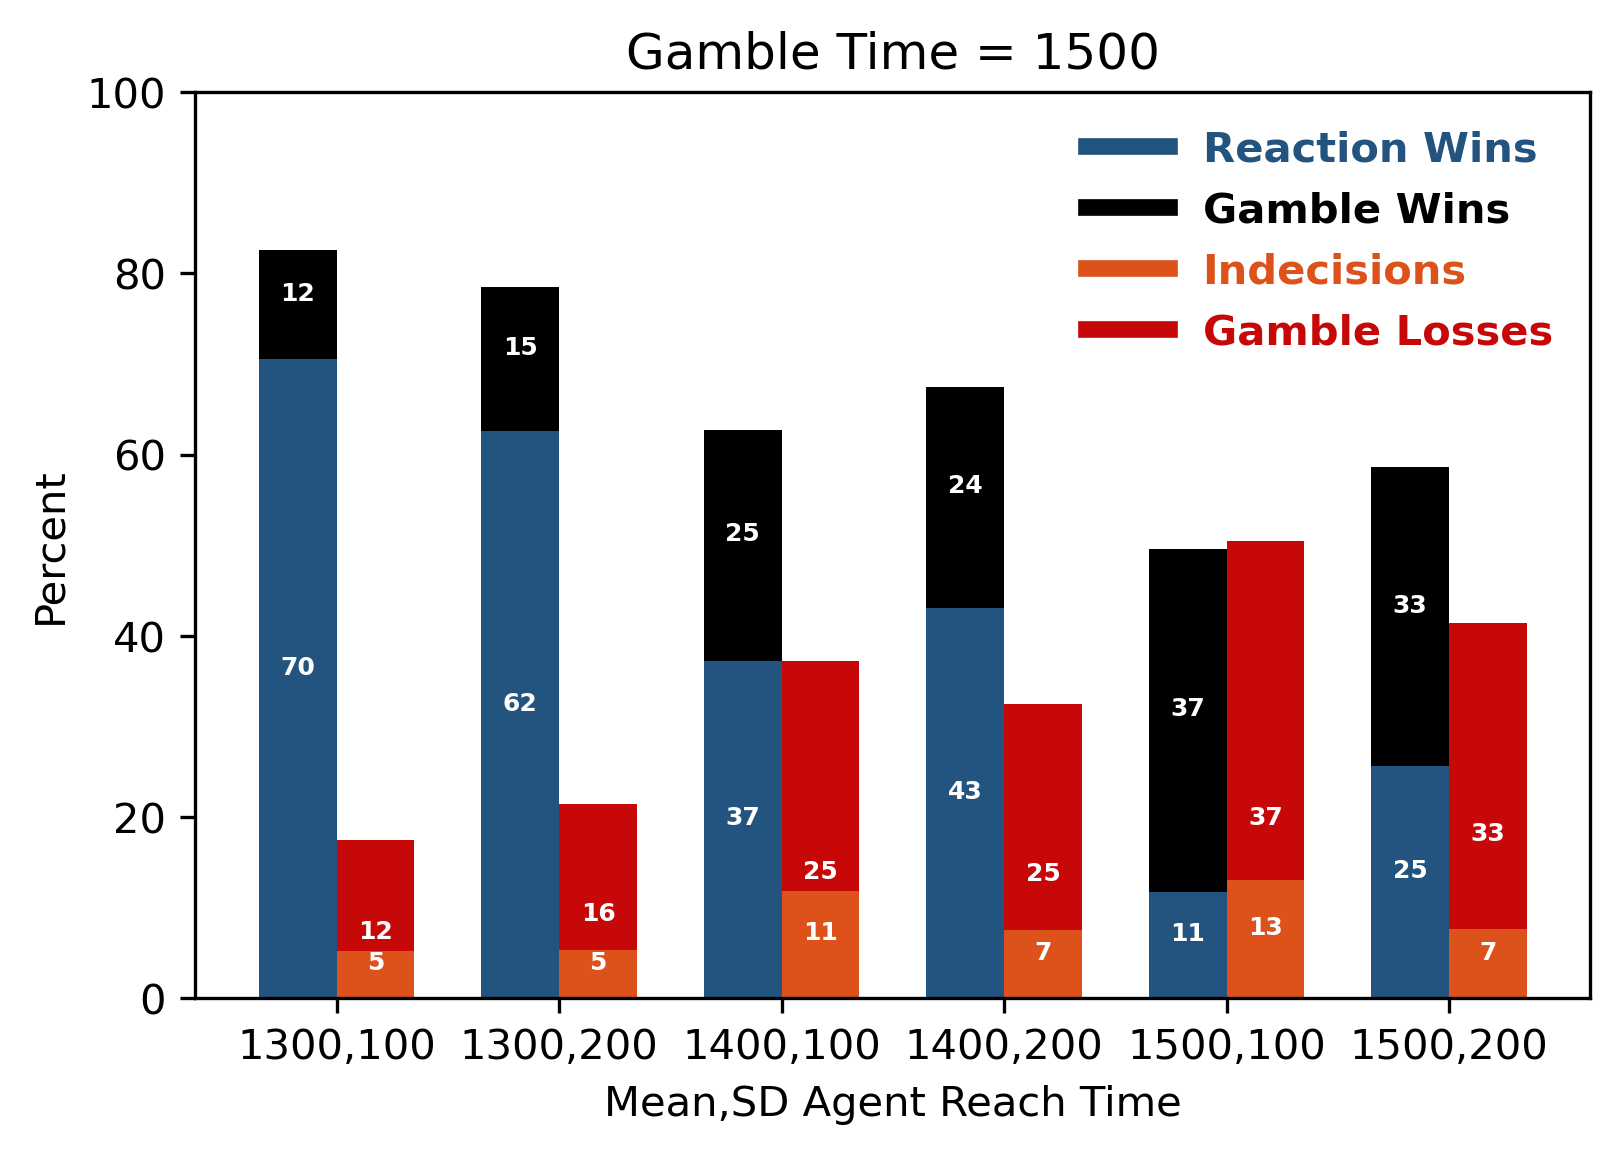

In [13]:
#%% Plot wins and indecisions for gambles and reactions
plt.figure(dpi = 300)
ax = plt.subplot()
xlocs = np.arange(num_blocks)
xlabs = ['1300,100', '1300,200','1400,100', '1400,200','1500,100', '1500,200']
width = 0.35
rect1 = ax.bar(xlocs - width/2 ,perc_reaction_wins, width = width, label = 'Reaction Wins', color = wheel.dark_blue)
rect2 = ax.bar(xlocs - width/2 ,perc_gamble_wins, width = width, label = 'Gamble Wins', color = 'black', bottom = perc_reaction_wins)
rect3 = ax.bar(xlocs + width/2, perc_indecisions, width = width, label = 'Indecisions', color = wheel.autumn)
rect4 = ax.bar(xlocs + width/2, perc_gamble_losses, width = width, label = 'Gamble Losses', color = wheel.dark_red, bottom = perc_indecisions)

ax.set_xticks(xlocs)
ax.set_xticklabels(xlabs)
ax.set_xlabel('Mean,SD Agent Reach Time')
ax.set_ylabel('Percent')
ax.set_ylim(0,100)

labels = ["Reaction Wins","Gamble Wins", "Indecisions", "Gamble Losses"]
colors = [wheel.dark_blue, 'black', wheel.autumn, wheel.dark_red]
dv.Custom_Legend(ax, labels, colors, fontsize = 10)
ax.set_title(f'Gamble Time Mean = {gamble_time_mean}')
for r1, r2, r3, r4 in zip(rect1, rect2, rect3, rect4):
    h1 = r1.get_height()
    h2 = r2.get_height()
    h3 = r3.get_height()
    h4 = r4.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h3 / 2., "%d" % h3, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")
    plt.text(r4.get_x() + r4.get_width() / 2., h4 / 2., "%d" % h4, ha="center", va="bottom", color="white", fontsize=6, fontweight="bold")


In [5]:
x = np.zeros((3,3,3))